# VIolin plot showing boost in Genes and UMIs per cell

Control versus depleted, masked 255 targeted genes, split into low, medium, high cells

In [1]:
import numpy as np
import pandas as pd
import scanpy as sc
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import mannwhitneyu, normaltest
from adjustText import adjust_text
from pandas.api.types import (
    is_numeric_dtype
)
from scipy.stats import rankdata
from statannotations.Annotator import Annotator


In [2]:
adata = sc.read_10x_h5('raw_files/Full_transcriptome_masked/Control_full_masked_filtered_feature_bc_matrix.h5')
adata.var_names_make_unique()
adata

/Users/jbezney/opt/anaconda3/envs/pegasus2/lib/python3.8/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


AnnData object with n_obs × n_vars = 11498 × 36346
    var: 'gene_ids', 'feature_types', 'genome'

In [3]:
sc.pp.filter_cells(adata, min_counts=500)
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)

In [4]:
mito_genes = adata.var_names.str.startswith('MT-')
# for each cell compute fraction of counts in mito genes vs. all genes
# the `.A1` is only necessary as X is sparse (to transform to a dense array after summing)
adata.obs['percent_mito'] = np.sum(
    adata[:, mito_genes].X, axis=1).A1 / np.sum(adata.X, axis=1).A1
# add the total counts per cell as observations-annotation to adata
adata.obs['n_counts'] = adata.X.sum(axis=1).A1

#determine the proper thresholds according to the 99% of the data
per_cell_metrics = adata.obs
quantile = pd.DataFrame()
quantile = per_cell_metrics.quantile(0.99, numeric_only=True)
quantile

n_counts        9310.240000
n_genes         3970.480000
percent_mito       0.001741
Name: 0.99, dtype: float64

In [5]:
#filter thresholds from 99% of all three metrics
adata = adata[adata.obs['n_counts'] < 9310.24, :]
adata

View of AnnData object with n_obs × n_vars = 11151 × 21151
    obs: 'n_counts', 'n_genes', 'percent_mito'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells'

In [6]:
control = pd.DataFrame(adata.obs)
control['label']= '10x-V3'
control

,n_counts,n_genes,percent_mito,label
AAACCCAAGAACGTGC-1,1550.0,1122,0.000000,10x-V3
AAACCCAAGACAGTCG-1,2222.0,1529,0.000450,10x-V3
AAACCCAAGGACAACC-1,2040.0,1468,0.000000,10x-V3
AAACCCAAGGTTTGAA-1,2581.0,1740,0.000387,10x-V3
AAACCCAAGTTAACGA-1,1828.0,1342,0.001094,10x-V3
...,...,...,...,...
TTTGTTGTCCACGGGT-1,5073.0,2677,0.000197,10x-V3
TTTGTTGTCGAGGCAA-1,859.0,712,0.002328,10x-V3
TTTGTTGTCGAGTCCG-1,1551.0,1117,0.000000,10x-V3
TTTGTTGTCGTTCAGA-1,1735.0,1261,0.000000,10x-V3


In [7]:
#split the data into three equivalent bins according to UMIs
lower = control['n_counts'].min()
upper = control['n_counts'].max()
interval = (upper - lower)/3

#create a function to categorize
def categorise(row):  
    if row['n_counts'] >= lower and row['n_counts'] <= (lower+interval):
        return 'Small'
    elif row['n_counts'] > (lower+interval) and row['n_counts'] <= (lower+(2*interval)):
        return 'Medium'
    elif row['n_counts'] > (lower+(2*interval))  and row['n_counts'] <= upper:
        return 'Large'
    
#apply the function
control['size'] = control.apply(lambda row: categorise(row), axis=1)
control

,n_counts,n_genes,percent_mito,label,size
AAACCCAAGAACGTGC-1,1550.0,1122,0.000000,10x-V3,Small
AAACCCAAGACAGTCG-1,2222.0,1529,0.000450,10x-V3,Small
AAACCCAAGGACAACC-1,2040.0,1468,0.000000,10x-V3,Small
AAACCCAAGGTTTGAA-1,2581.0,1740,0.000387,10x-V3,Small
AAACCCAAGTTAACGA-1,1828.0,1342,0.001094,10x-V3,Small
...,...,...,...,...,...
TTTGTTGTCCACGGGT-1,5073.0,2677,0.000197,10x-V3,Medium
TTTGTTGTCGAGGCAA-1,859.0,712,0.002328,10x-V3,Small
TTTGTTGTCGAGTCCG-1,1551.0,1117,0.000000,10x-V3,Small
TTTGTTGTCGTTCAGA-1,1735.0,1261,0.000000,10x-V3,Small


In [8]:
#split the data into three equivalent bins according to genes
lower = control['n_genes'].min()
upper = control['n_genes'].max()
interval = (upper - lower)/3

#create a function to categorize
def categorise(row):  
    if row['n_genes'] >= lower and row['n_genes'] <= (lower+interval):
        return 'Small'
    elif row['n_genes'] > (lower+interval) and row['n_genes'] <= (lower+(2*interval)):
        return 'Medium'
    elif row['n_genes'] > (lower+(2*interval))  and row['n_genes'] <= upper:
        return 'Large'
    
#apply the function
control['gene_filter'] = control.apply(lambda row: categorise(row), axis=1)
control

,n_counts,n_genes,percent_mito,label,size,gene_filter
AAACCCAAGAACGTGC-1,1550.0,1122,0.000000,10x-V3,Small,Small
AAACCCAAGACAGTCG-1,2222.0,1529,0.000450,10x-V3,Small,Small
AAACCCAAGGACAACC-1,2040.0,1468,0.000000,10x-V3,Small,Small
AAACCCAAGGTTTGAA-1,2581.0,1740,0.000387,10x-V3,Small,Medium
AAACCCAAGTTAACGA-1,1828.0,1342,0.001094,10x-V3,Small,Small
...,...,...,...,...,...,...
TTTGTTGTCCACGGGT-1,5073.0,2677,0.000197,10x-V3,Medium,Medium
TTTGTTGTCGAGGCAA-1,859.0,712,0.002328,10x-V3,Small,Small
TTTGTTGTCGAGTCCG-1,1551.0,1117,0.000000,10x-V3,Small,Small
TTTGTTGTCGTTCAGA-1,1735.0,1261,0.000000,10x-V3,Small,Small


Perform the same for depleted sample 

In [9]:
data = sc.read_10x_h5('raw_files/Full_transcriptome_masked/Depleted_rep3_full_masked_filtered_feature_bc_matrix.h5')
data.var_names_make_unique()
data

/Users/jbezney/opt/anaconda3/envs/pegasus2/lib/python3.8/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


AnnData object with n_obs × n_vars = 11733 × 36346
    var: 'gene_ids', 'feature_types', 'genome'

In [10]:
sc.pp.filter_cells(data, min_counts=500)
sc.pp.filter_cells(data, min_genes=200)
sc.pp.filter_genes(data, min_cells=3)

In [11]:
mito_genes = data.var_names.str.startswith('MT-')
# for each cell compute fraction of counts in mito genes vs. all genes
# the `.A1` is only necessary as X is sparse (to transform to a dense array after summing)
data.obs['percent_mito'] = np.sum(
    data[:, mito_genes].X, axis=1).A1 / np.sum(data.X, axis=1).A1
# add the total counts per cell as observations-annotation to adata
data.obs['n_counts'] = data.X.sum(axis=1).A1

#determine the proper thresholds according to the 99% of the data
per_cell_metrics = data.obs
quantile = pd.DataFrame()
quantile = per_cell_metrics.quantile(0.99, numeric_only=True)
quantile

n_counts        12202.000000
n_genes          4676.050000
percent_mito        0.000884
Name: 0.99, dtype: float64

In [12]:
#filter thresholds from 99% of all three metrics
data = data[data.obs['n_counts'] < 12202.0, :]
data

View of AnnData object with n_obs × n_vars = 11364 × 21197
    obs: 'n_counts', 'n_genes', 'percent_mito'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells'

In [13]:
depleted = pd.DataFrame(data.obs)
depleted['label']= 'scCLEAN'
depleted

,n_counts,n_genes,percent_mito,label
AAACCCAAGGACGGAG-1,3024.0,1352,0.000000,scCLEAN
AAACCCACAATCCTTT-1,2218.0,1593,0.000000,scCLEAN
AAACCCACAATTGGTC-1,4607.0,2524,0.000000,scCLEAN
AAACCCACACCCGTAG-1,3525.0,2150,0.000284,scCLEAN
AAACCCACATAGCTGT-1,2908.0,1967,0.000344,scCLEAN
...,...,...,...,...
TTTGTTGTCAACACCA-1,2533.0,1694,0.000000,scCLEAN
TTTGTTGTCAGGACAG-1,3779.0,2231,0.000000,scCLEAN
TTTGTTGTCCCTCGTA-1,6161.0,3213,0.000000,scCLEAN
TTTGTTGTCGCCGAGT-1,1245.0,991,0.000000,scCLEAN


In [14]:
#split the data into three equivalent bins according to UMIs
lower = depleted['n_counts'].min()
upper = depleted['n_counts'].max()
interval = (upper - lower)/3

#create a function to categorize
def categorise(row):  
    if row['n_counts'] >= lower and row['n_counts'] <= (lower+interval):
        return 'Small'
    elif row['n_counts'] > (lower+interval) and row['n_counts'] <= (lower+(2*interval)):
        return 'Medium'
    elif row['n_counts'] > (lower+(2*interval))  and row['n_counts'] <= upper:
        return 'Large'
    
#apply the function
depleted['size'] = depleted.apply(lambda row: categorise(row), axis=1)
depleted

,n_counts,n_genes,percent_mito,label,size
AAACCCAAGGACGGAG-1,3024.0,1352,0.000000,scCLEAN,Small
AAACCCACAATCCTTT-1,2218.0,1593,0.000000,scCLEAN,Small
AAACCCACAATTGGTC-1,4607.0,2524,0.000000,scCLEAN,Medium
AAACCCACACCCGTAG-1,3525.0,2150,0.000284,scCLEAN,Small
AAACCCACATAGCTGT-1,2908.0,1967,0.000344,scCLEAN,Small
...,...,...,...,...,...
TTTGTTGTCAACACCA-1,2533.0,1694,0.000000,scCLEAN,Small
TTTGTTGTCAGGACAG-1,3779.0,2231,0.000000,scCLEAN,Small
TTTGTTGTCCCTCGTA-1,6161.0,3213,0.000000,scCLEAN,Medium
TTTGTTGTCGCCGAGT-1,1245.0,991,0.000000,scCLEAN,Small


In [15]:
#split the data into three equivalent bins according to genes
lower = depleted['n_genes'].min()
upper = depleted['n_genes'].max()
interval = (upper - lower)/3

#create a function to categorize
def categorise(row):  
    if row['n_genes'] >= lower and row['n_genes'] <= (lower+interval):
        return 'Small'
    elif row['n_genes'] > (lower+interval) and row['n_genes'] <= (lower+(2*interval)):
        return 'Medium'
    elif row['n_genes'] > (lower+(2*interval))  and row['n_genes'] <= upper:
        return 'Large'
    
#apply the function
depleted['gene_filter'] = depleted.apply(lambda row: categorise(row), axis=1)
depleted

,n_counts,n_genes,percent_mito,label,size,gene_filter
AAACCCAAGGACGGAG-1,3024.0,1352,0.000000,scCLEAN,Small,Small
AAACCCACAATCCTTT-1,2218.0,1593,0.000000,scCLEAN,Small,Small
AAACCCACAATTGGTC-1,4607.0,2524,0.000000,scCLEAN,Medium,Medium
AAACCCACACCCGTAG-1,3525.0,2150,0.000284,scCLEAN,Small,Medium
AAACCCACATAGCTGT-1,2908.0,1967,0.000344,scCLEAN,Small,Medium
...,...,...,...,...,...,...
TTTGTTGTCAACACCA-1,2533.0,1694,0.000000,scCLEAN,Small,Small
TTTGTTGTCAGGACAG-1,3779.0,2231,0.000000,scCLEAN,Small,Medium
TTTGTTGTCCCTCGTA-1,6161.0,3213,0.000000,scCLEAN,Medium,Medium
TTTGTTGTCGCCGAGT-1,1245.0,991,0.000000,scCLEAN,Small,Small


In [16]:
#merge and plot 
merged = pd.concat([control, depleted], ignore_index=True)
merged['UMI_filter'] = merged['size'].astype(str)
merged['GENE_filter'] = merged['gene_filter'].astype(str)
merged

,n_counts,n_genes,percent_mito,label,size,gene_filter,UMI_filter,GENE_filter
0,1550.0,1122,0.000000,10x-V3,Small,Small,Small,Small
1,2222.0,1529,0.000450,10x-V3,Small,Small,Small,Small
2,2040.0,1468,0.000000,10x-V3,Small,Small,Small,Small
3,2581.0,1740,0.000387,10x-V3,Small,Medium,Small,Medium
4,1828.0,1342,0.001094,10x-V3,Small,Small,Small,Small
...,...,...,...,...,...,...,...,...
22510,2533.0,1694,0.000000,scCLEAN,Small,Small,Small,Small
22511,3779.0,2231,0.000000,scCLEAN,Small,Medium,Small,Medium
22512,6161.0,3213,0.000000,scCLEAN,Medium,Medium,Medium,Medium
22513,1245.0,991,0.000000,scCLEAN,Small,Small,Small,Small


/var/folders/fv/spz1kmdd6fzcpgwh4n4pgtxh0000gn/T/ipykernel_21288/865106499.py:36: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(ax.get_ymajorticklabels(), fontsize = 14)


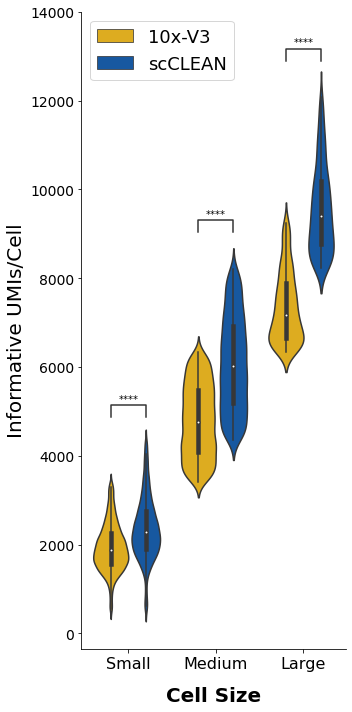

In [35]:
#generate violin plots to compare
colors_list = ['#fcbb00', '#0057B7']

hue_plot_params = {
    'data':      merged,
    'x':         'UMI_filter',
    'y':         'n_counts',
    "hue":       'label',
    "palette":   colors_list
}

pairs = (
    [('Small', 'scCLEAN'), ('Small', '10x-V3')], 
    [('Medium', 'scCLEAN'), ('Medium', '10x-V3')],
    [('Large', 'scCLEAN'), ('Large', '10x-V3')]
)

               
fig = plt.figure(figsize=(5, 10))
ax = sns.violinplot(x=merged.UMI_filter, y=merged.n_counts, hue=merged.label, data=merged, palette=colors_list)

handles, labels = ax.get_legend_handles_labels()
ax.legend(handles=handles[0:], labels=labels[0:], loc="upper left", fontsize=18)
ax.set_xticklabels(ax.get_xmajorticklabels(), fontsize = 16)


annotator = Annotator(ax, pairs, **hue_plot_params)  
annotator.configure(test="Mann-Whitney", comparisons_correction="BH", verbose=False, loc='inside').apply_and_annotate()


ax.set_ylabel("Informative UMIs/Cell", fontsize=20)
ax.set_xlabel("Cell Size", fontsize=20, fontweight="bold")
ax.xaxis.labelpad = 15
sns.despine()

ax.set_yticklabels(ax.get_ymajorticklabels(), fontsize = 14)

plt.tight_layout()
plt.savefig('Figures/PBMC_Boost_UMIs_per_cell.png', dpi=300)
plt.show()


/var/folders/fv/spz1kmdd6fzcpgwh4n4pgtxh0000gn/T/ipykernel_21288/444670919.py:37: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(ax.get_ymajorticklabels(), fontsize = 14)


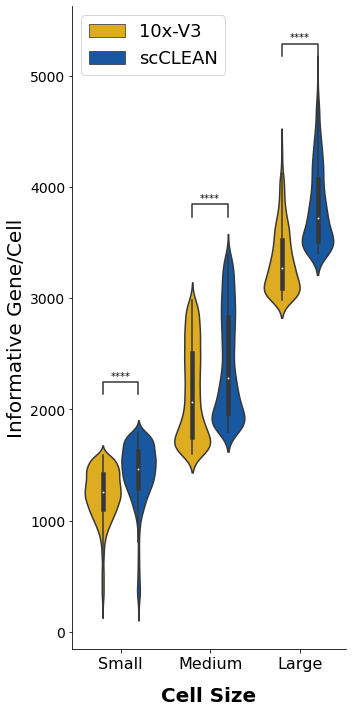

In [36]:
#generate violin plots to compare
colors_list = ['#fcbb00', '#0057B7']

hue_plot_params = {
    'data':      merged,
    'x':         'GENE_filter',
    'y':         'n_genes',
    "hue":       'label',
    "palette":   colors_list
}

pairs = (
    [('Small', 'scCLEAN'), ('Small', '10x-V3')], 
    [('Medium', 'scCLEAN'), ('Medium', '10x-V3')],
    [('Large', 'scCLEAN'), ('Large', '10x-V3')]
)

               
fig = plt.figure(figsize=(5, 10))
ax = sns.violinplot(x=merged.GENE_filter, y=merged.n_genes, hue=merged.label, data=merged, palette=colors_list)

handles, labels = ax.get_legend_handles_labels()
ax.legend(handles=handles[0:], labels=labels[0:], loc="upper left", fontsize=18)
ax.set_xticklabels(ax.get_xmajorticklabels(), fontsize = 16)


annotator = Annotator(ax, pairs, **hue_plot_params)  
annotator.configure(test="Mann-Whitney", comparisons_correction="BH", verbose=False, 
                    loc='inside').apply_and_annotate()


ax.set_ylabel("Informative Gene/Cell", fontsize=20)
ax.set_xlabel("Cell Size", fontsize=20, fontweight="bold")
ax.xaxis.labelpad = 15
sns.despine()

ax.set_yticklabels(ax.get_ymajorticklabels(), fontsize = 14)

plt.tight_layout()
plt.savefig('Figures/PBMC_Boost_GENEs_per_cell.png', dpi=300)
plt.show()